# **DA5401 A6 (Imputation via Regression for Missing Data)**

### **Dependencies**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## **Part A: Data Preprocessing and Imputation**

### **Load and Prepare Data**

Dataset: [Default of Credit Card Clients Dataset](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset)  
- **Target:** `default.payment.next.month` (1 →  Yes, 0 → No)

**Steps:**
- The dataset was downloaded using the Kaggle CLI and loaded as a pandas dataframe
- Introduced **artificially introduced Missing At Random (MAR) values** by replacing 5% of the values in three numerical columns (`AGE`, `BILL_AMT1`, `BILL_AMT2`) with `NaN`.

In [2]:
# Downloading dataset using kaggle cli
# kaggle datasets download -d uciml/default-of-credit-card-clients-dataset -p ./datasets --unzip

In [3]:
ucc_df = pd.read_csv('datasets/UCI_Credit_Card.csv')

In [4]:
ucc_df.shape

(30000, 25)

In [5]:
ucc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [6]:
ucc_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
ucc_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [8]:
ucc_df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [9]:
# We can see some class imbalance in the data
ucc_df['default.payment.next.month'].value_counts(normalize=True)

default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [10]:
np.random.seed(42)

cols_with_missing = ['AGE', 'BILL_AMT1', 'BILL_AMT2']
missing_pct = 0.05

for col in cols_with_missing:
    missing_indices = ucc_df.sample(frac=missing_pct).index
    ucc_df.loc[missing_indices, col] = np.nan

In [11]:
ucc_df.isna().sum()

ID                               0
LIMIT_BAL                        0
SEX                              0
EDUCATION                        0
MARRIAGE                         0
AGE                           1500
PAY_0                            0
PAY_2                            0
PAY_3                            0
PAY_4                            0
PAY_5                            0
PAY_6                            0
BILL_AMT1                     1500
BILL_AMT2                     1500
BILL_AMT3                        0
BILL_AMT4                        0
BILL_AMT5                        0
BILL_AMT6                        0
PAY_AMT1                         0
PAY_AMT2                         0
PAY_AMT3                         0
PAY_AMT4                         0
PAY_AMT5                         0
PAY_AMT6                         0
default.payment.next.month       0
dtype: int64

In [12]:
ucc_df[cols_with_missing].isnull().mean()

AGE          0.05
BILL_AMT1    0.05
BILL_AMT2    0.05
dtype: float64

### **Imputation Strategy 1: Simple Imputation (Baseline)**

- **Copy:** we create a copy of the dataset.
- **Detection:** We automatically identify all columns with missing values.
- **Imputation:** For each column with missing values, we use the `SimpleImputer` from scikit-learn with the `'median'` strategy to fill in the missing entries.

In [13]:
dataset_a = ucc_df.copy()

In [14]:
# Automatically find columns with missing values
cols_with_missing = dataset_a.columns[dataset_a.isnull().any()].tolist()

# Impute only columns with missing values
simple_imputer = SimpleImputer(strategy='median')
dataset_a[cols_with_missing] = simple_imputer.fit_transform(dataset_a[cols_with_missing])

In [15]:
dataset_a.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

### **Imputation Strategy 2: Regression Imputation (Linear)**

- We use scikit-learn's `IterativeImputer` with a linear regression estimator to iteratively predict and impute missing values in all numeric columns.
- Each feature with missing values is modeled as a function of the other features, including the target variable, and missing values are predicted using linear regression.
- This process is repeated for several iterations, allowing the imputer to use previously imputed values as predictors in subsequent steps.
- This approach is well-suited for data that is **Missing At Random (MAR)**, where the probability of missingness depends on observed data.

**Advantages:**
- More accurate than simple imputation, as it leverages relationships between features.
- Can handle multiple columns with missing values, even when missingness overlaps.

**Underlying Assumption (Missing At Random - MAR):**  
- The MAR assumption means that the likelihood of a value being missing depends only on the observed data, not on the value of the missing data itself. In other words, the missingness can be explained by other variables in the dataset, making regression-based imputation appropriate.

**Note:**  
- `IterativeImputer` is experimental in scikit-learn and works only with numeric columns by default.
- `IterativeImputer` only fills in the missing (`NaN`) entries in the data. The observed (non-missing) values remain unchanged throughout the imputation process, ensuring that the original, real data is preserved.

In [16]:
dataset_b = ucc_df.copy()

In [17]:
# Select only numeric columns for imputation (IterativeImputer works with numeric data)
numeric_cols = dataset_b.select_dtypes(include=[np.number]).columns

# Initialize IterativeImputer (uses BayesianRidge by default, can set estimator=LinearRegression())
imputer = IterativeImputer(random_state=42, estimator=LinearRegression())
dataset_b[numeric_cols] = imputer.fit_transform(dataset_b[numeric_cols])

In [18]:
dataset_b.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

### **Imputation Strategy 3: Regression Imputation (Non-Linear)**

- We create a third dataset copy and use `KNNImputer` (K-Nearest Neighbors Imputer) from scikit-learn to fill in missing values for all numeric columns.
- KNNImputer estimates each missing value based on the values of its nearest neighbors, capturing non-linear relationships in the data.
- This approach is effective for datasets where the relationship between features is not strictly linear.

**Note:**  
- We also experimented with tree-based models (`DecisionTreeRegressor` and `RandomForestRegressor`) using `IterativeImputer`.
- The Decision Tree approach did **not converge** (the imputer could not stabilize the imputed values).
- The Random Forest approach was **computationally expensive** and took too long to run.
- Therefore, we chose **KNNImputer** as the practical non-linear imputation method for this assignment.

In [19]:
dataset_c = ucc_df.copy()

In [20]:
# Select only numeric columns for imputation (KNNImputer works with numeric data)
numeric_cols = dataset_c.select_dtypes(include=[np.number]).columns

# Initialize KNNImputer (non-linear regression-based imputation)
knn_imputer = KNNImputer()
dataset_c[numeric_cols] = knn_imputer.fit_transform(dataset_c[numeric_cols])

In [21]:
dataset_c.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

# **Part B: Model Training and Performance Assessment**

### **Strategy 4: Remove nulls**

In [22]:
dataset_d = ucc_df.dropna()

### **Data Split**

In [23]:
target_column = 'default.payment.next.month'

# Dataset A: Simple Imputation
X_a = dataset_a.drop(columns=[target_column])
y_a = dataset_a[target_column]
X_a_train, X_a_test, y_a_train, y_a_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)

# Dataset B: Regression Imputation (Linear)
X_b = dataset_b.drop(columns=[target_column])
y_b = dataset_b[target_column]
X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Dataset C: Regression Imputation (Non-Linear)
X_c = dataset_c.drop(columns=[target_column])
y_c = dataset_c[target_column]
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

# Dataset D: Deletion (remove all rows with any missing values)
X_d = dataset_d.drop(columns=[target_column])
y_d = dataset_d[target_column]
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

### **Classifier Setup**

- We use a scikit-learn `Pipeline` to streamline preprocessing and model training.
- The pipeline first standardizes all features using `StandardScaler`.
- Then, it fits a `LogisticRegression` classifier (`random_state=42`).
- This setup ensures consistent scaling and easy model fitting/prediction for all datasets.

In [24]:
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced', random_state=42))
])

### **Model Evaluation**

* `evaluate_model()` fits the pipeline and makes predictions.
* Prints the classification report and confusion matrix.
* Compares model performance across datasets with different imputation strategies:

  * A: Median Imputation
  * B: Linear Regression Imputation
  * C: KNN Imputation
  * D: Row Deletion

In [25]:
# Helper function to fit, predict, and print reports
def evaluate_model(X_train, X_test, y_train, y_test, label):
    clf_pipeline.fit(X_train, y_train)
    y_pred = clf_pipeline.predict(X_test)
    print(f"--- {label} ---")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    disp.plot()
    plt.show()
    # Force inclusion of both classes (0 and 1)
    return classification_report(y_test, y_pred, output_dict=True, labels=[0, 1], zero_division=0)

--- Dataset A: Simple Imputation (median) ---
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4687
           1       0.38      0.65      0.48      1313

    accuracy                           0.69      6000
   macro avg       0.63      0.67      0.63      6000
weighted avg       0.77      0.69      0.71      6000

Confusion Matrix:


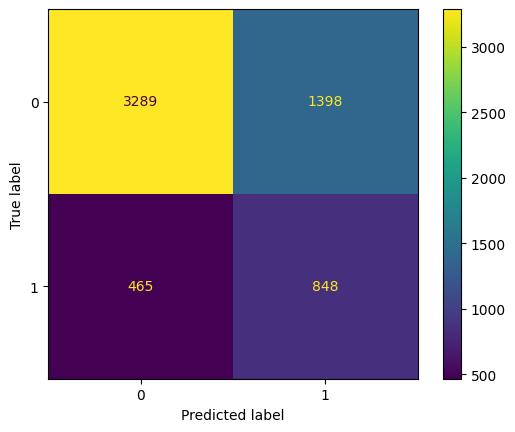

In [26]:
cr_a = evaluate_model(X_a_train, X_a_test, y_a_train, y_a_test, "Dataset A: Simple Imputation (median)")

--- Dataset B: Linear Imputation (Linear Regression) ---
              precision    recall  f1-score   support

         0.0       0.88      0.71      0.78      4687
         1.0       0.38      0.65      0.48      1313

    accuracy                           0.69      6000
   macro avg       0.63      0.68      0.63      6000
weighted avg       0.77      0.69      0.72      6000

Confusion Matrix:


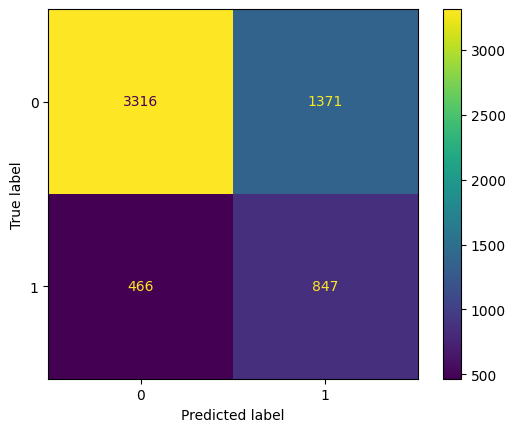

In [27]:
cr_b = evaluate_model(X_b_train, X_b_test, y_b_train, y_b_test, "Dataset B: Linear Imputation (Linear Regression)")

--- Dataset C: Non-Linear Imputation (KNN) ---
              precision    recall  f1-score   support

         0.0       0.88      0.70      0.78      4687
         1.0       0.38      0.64      0.48      1313

    accuracy                           0.69      6000
   macro avg       0.63      0.67      0.63      6000
weighted avg       0.77      0.69      0.71      6000

Confusion Matrix:


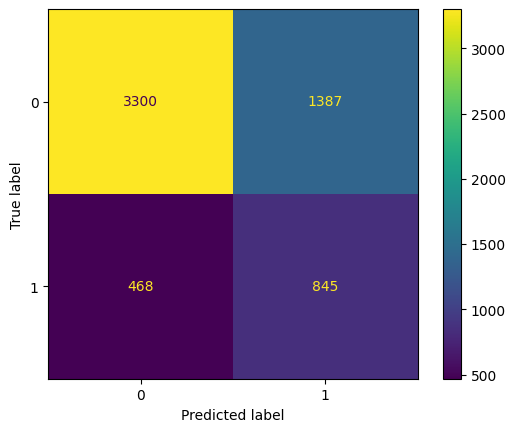

In [28]:
cr_c = evaluate_model(X_c_train, X_c_test, y_c_train, y_c_test, "Dataset C: Non-Linear Imputation (KNN)")

--- Dataset D: Deletion (Remove rows with null) ---
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      4040
           1       0.37      0.64      0.46      1106

    accuracy                           0.68      5146
   macro avg       0.62      0.67      0.62      5146
weighted avg       0.77      0.68      0.71      5146

Confusion Matrix:


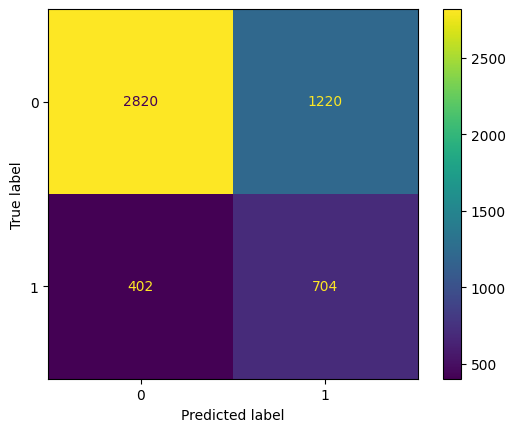

In [29]:
cr_d = evaluate_model(X_d_train, X_d_test, y_d_train, y_d_test, "Dataset D: Deletion (Remove rows with null)")

## **Part C: Comparative Analysis**

### **Results Comparison**

* A summary table was created to compare the performance of four models on the same dataset.
* Models compared:

  1. **Model A:** Median Imputation
  2. **Model B:** Linear Regression Imputation
  3. **Model C:** Non-Linear Regression (KNN) Imputation
  4. **Model D:** Listwise Deletion (removing rows with missing values)
* Key performance metrics included:

  * **Precision, Recall, F1-score** for each class (0 and 1)
  * **Overall Accuracy**
* Metrics were extracted from the `classification_report` using `output_dict=True`.
* A **bar plot visualization** was used to compare metrics across models for better interpretability.
* The comparison highlights how different imputation strategies affect model performance, especially on minority classes in imbalanced datasets.

In [30]:
def get_metric(report, label, metric):
    # Handles both numeric and string keys safely
    if label in report:
        return report[label][metric]
    elif str(label) in report:
        return report[str(label)][metric]
    else:
        return None

summary = {
    "Model": ["A: Median", "B: Linear", "C: KNN", "D: Deletion"],
    "Precision (Class 0)": [get_metric(cr_a, 0, "precision"), get_metric(cr_b, 0, "precision"), get_metric(cr_c, 0, "precision"), get_metric(cr_d, 0, "precision")],
    "Recall (Class 0)":    [get_metric(cr_a, 0, "recall"),    get_metric(cr_b, 0, "recall"),    get_metric(cr_c, 0, "recall"),    get_metric(cr_d, 0, "recall")],
    "F1-score (Class 0)":  [get_metric(cr_a, 0, "f1-score"),  get_metric(cr_b, 0, "f1-score"),  get_metric(cr_c, 0, "f1-score"),  get_metric(cr_d, 0, "f1-score")],
    "Precision (Class 1)": [get_metric(cr_a, 1, "precision"), get_metric(cr_b, 1, "precision"), get_metric(cr_c, 1, "precision"), get_metric(cr_d, 1, "precision")],
    "Recall (Class 1)":    [get_metric(cr_a, 1, "recall"),    get_metric(cr_b, 1, "recall"),    get_metric(cr_c, 1, "recall"),    get_metric(cr_d, 1, "recall")],
    "F1-score (Class 1)":  [get_metric(cr_a, 1, "f1-score"),  get_metric(cr_b, 1, "f1-score"),  get_metric(cr_c, 1, "f1-score"),  get_metric(cr_d, 1, "f1-score")],
    "Accuracy":            [cr_a["accuracy"], cr_b["accuracy"], cr_c["accuracy"], cr_d["accuracy"]]
}

summary_df = pd.DataFrame(summary).round(3)
summary_df

,Model,Precision (Class 0),Recall (Class 0),F1-score (Class 0),Precision (Class 1),Recall (Class 1),F1-score (Class 1),Accuracy
0,A: Median,0.876,0.702,0.779,0.378,0.646,0.477,0.690
1,B: Linear,0.877,0.707,0.783,0.382,0.645,0.480,0.694
2,C: KNN,0.876,0.704,0.781,0.379,0.644,0.477,0.691
3,D: Deletion,0.875,0.698,0.777,0.366,0.637,0.465,0.685


In [31]:
# Set Seaborn style and palette
sns.set(palette="colorblind")

models = ["A: Median", "B: Linear", "C: KNN", "D: Deletion"]
x = np.arange(len(models))
width = 0.2

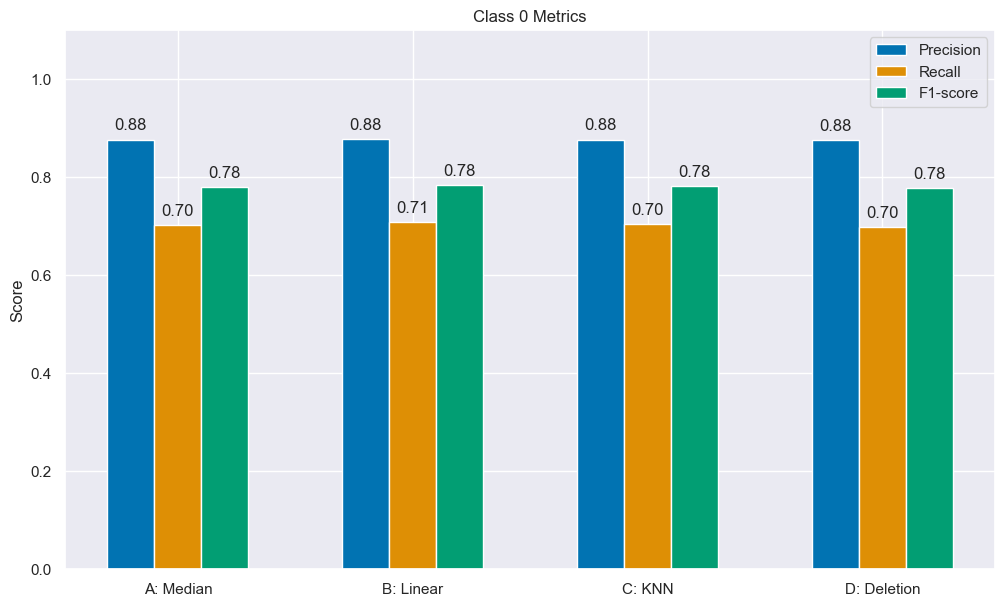

In [32]:
# ---- Plot 1: Class 0 Metrics ----
plt.figure(figsize=(12,7))
plt.bar(x - width, summary_df["Precision (Class 0)"], width, label='Precision')
plt.bar(x, summary_df["Recall (Class 0)"], width, label='Recall')
plt.bar(x + width, summary_df["F1-score (Class 0)"], width, label='F1-score')

# Annotate values on top
for i in range(len(models)):
    plt.text(i - width, summary_df["Precision (Class 0)"][i] + 0.02, f"{summary_df['Precision (Class 0)'][i]:.2f}", ha='center')
    plt.text(i, summary_df["Recall (Class 0)"][i] + 0.02, f"{summary_df['Recall (Class 0)'][i]:.2f}", ha='center')
    plt.text(i + width, summary_df["F1-score (Class 0)"][i] + 0.02, f"{summary_df['F1-score (Class 0)'][i]:.2f}", ha='center')

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Class 0 Metrics")
plt.legend()
plt.show()

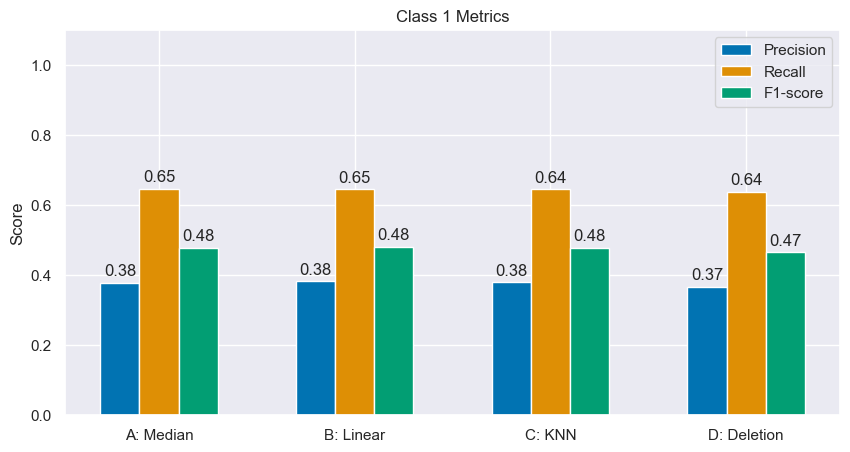

In [33]:
# ---- Plot 2: Class 1 Metrics ----
plt.figure(figsize=(10,5))
plt.bar(x - width, summary_df["Precision (Class 1)"], width, label='Precision')
plt.bar(x, summary_df["Recall (Class 1)"], width, label='Recall')
plt.bar(x + width, summary_df["F1-score (Class 1)"], width, label='F1-score')

# Annotate values on top
for i in range(len(models)):
    plt.text(i - width, summary_df["Precision (Class 1)"][i] + 0.02, f"{summary_df['Precision (Class 1)'][i]:.2f}", ha='center')
    plt.text(i, summary_df["Recall (Class 1)"][i] + 0.02, f"{summary_df['Recall (Class 1)'][i]:.2f}", ha='center')
    plt.text(i + width, summary_df["F1-score (Class 1)"][i] + 0.02, f"{summary_df['F1-score (Class 1)'][i]:.2f}", ha='center')

plt.xticks(x, models)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Class 1 Metrics")
plt.legend()
plt.show()

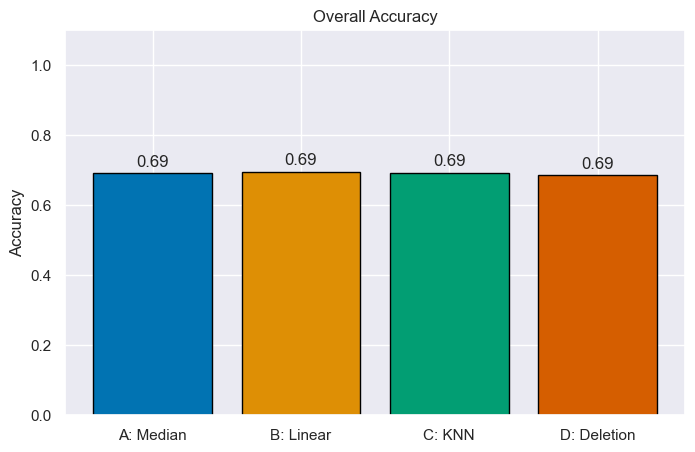

In [34]:
# ---- Plot 3: Overall Accuracy ----
plt.figure(figsize=(8,5))
plt.bar(models, summary_df["Accuracy"], color=sns.color_palette("colorblind"), edgecolor='black')

# Annotate values
for i, val in enumerate(summary_df["Accuracy"]):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center')

plt.ylim(0, 1.1)
plt.ylabel("Accuracy")
plt.title("Overall Accuracy")
plt.show()

### **Efficacy Discussion**

This analysis evaluates the effectiveness of four different strategies for handling missing data: median imputation (A), linear regression imputation (B), K-Nearest Neighbors (KNN) imputation (C), and listwise deletion (D). The best strategy is determined by comparing classification performance and considering the conceptual trade-offs of each method.

***

#### **Deletion vs. Imputation**

The core trade-off here is between the simplicity of deleting data versus the statistical power gained by imputing it.

* **Listwise Deletion (Model D)**, which removes any row with missing values, was the worst-performing strategy. It achieved an **accuracy of 0.685** and a **Class 1 F1-score of 0.465**. While simple, this method significantly reduces the dataset size. This data loss leads to:
    * 📉 **Reduced Statistical Power**: The model has less data to learn from, making it harder to identify patterns, especially for the minority class (defaulters).
    * biased **Potential for Bias**: Since the missingness was Missing At Random (MAR), deleting rows can skew the dataset's distribution, leading to a biased model.

* **Imputation (Models A, B, C)** consistently outperformed deletion because it preserves the entire dataset. Even the baseline **Median Imputation (Model A)** achieved a higher accuracy (0.690) and Class 1 F1-score (0.477).

Ultimately, the harm caused by **significant data loss** from deletion was more detrimental to model performance than the potential noise introduced by estimating values through imputation.

***

#### **Linear vs. Non-Linear Imputation**

When comparing the regression-based methods, the **Linear Regression Imputation (Model B)** performed slightly better than the **Non-Linear KNN Imputation (Model C)**.

* **Model B (Linear):** Accuracy = 0.694, F1-score (Class 1) = 0.480
* **Model C (KNN):** Accuracy = 0.691, F1-score (Class 1) = 0.477

The `IterativeImputer` with a linear model assumes that the missing features can be predicted as a **linear combination** of the other features. `KNNImputer` makes no such assumption, instead using the average of the nearest neighbors to capture more complex, non-linear patterns.

Since the linear method performed best, it suggests that the relationships between the features in this dataset are **predominantly linear**. The added complexity of KNN was not necessary and offered no performance advantage, making the `IterativeImputer`'s approach the most effective.

***

#### **Recommendation**

For this scenario, the best strategy for handling missing data is **Linear Regression Imputation using `IterativeImputer` (Model B)**.

This recommendation is justified on three key points:
1.  **Superior Performance**: It delivered the highest overall accuracy (0.694) and, most importantly, the highest F1-score for the minority class (0.480). Correctly identifying defaulters is critical, making this metric paramount.
2.  **Data Preservation**: It retains the full dataset, avoiding the power loss and bias associated with listwise deletion.
3.  **Appropriate Complexity**: It is more sophisticated than simple median imputation but avoids the unnecessary computational overhead and slight performance dip of the non-linear KNN method, indicating it is the best fit for the underlying data structure.